In [1]:
# Imports
import simulation as sim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
from tqdm import tqdm

sim.main_exe = '../build/crystal'
import collapser as coll

In [2]:
# Phase 0: define variables and used parameters for run(). Should be reloaded from file for the analysis.
nu = 0.63
beta = 0.33
crystals = {
    'lattice': {
        'params': {
            'f': '../cellfiles/lattice_cell.txt',
            't': 100001,
            'p': 0.11,
            'B': 0,
            'L': 8,
        },
        'LL': range(7, 23, 3),
        'bb': np.linspace(0.2, 0.26, 12),
        'name': 'Standard lattice',
        'bc': 0.24,
    },
    'body': {
        'params': {
            'f': '../cellfiles/bodyCenteredCubic_cell.txt',
            't': 30001,
            'p': 0.12,
            'B': 0,
            'L': 6,
        },
        'LL': range(4, 7),
        'bb': np.linspace(0.08, 0.20, 12),
        'name': 'Body centered cubic',
        'bc': 0.12,
    },
    'face': {
        'params': {
            'f': '../cellfiles/faceCenteredCubic_cell.txt',
            't': 30001,
            'p': 0.12,
            'B': 0,
            'L': 5,
        },
        'LL': range(4, 7),
        'bb': np.linspace(0.10, 0.24, 12),
        'name': 'Face centered cubic',
        'bc': 0.14,
    },
    'diamond': {
        'params': {
            'f': '../cellfiles/diamond_cell.txt',
            't': 30001,
            'p': 0.12,
            'B': 0,
            'L': 4,
        },
        'LL': range(4, 7),
        'bb': np.linspace(0.18, 0.4, 12),
        'name': 'Diamond cubic',
        'bc': 0.26,
    },
}

Standard lattice
{'B': '0',
 'J': '1',
 'L': '8',
 'b': '0.256364',
 'cell.N': '1',
 'f': '../cellfiles/lattice_cell.txt',
 'model_size': '512',
 'p': '0.12',
 't': '50001'}


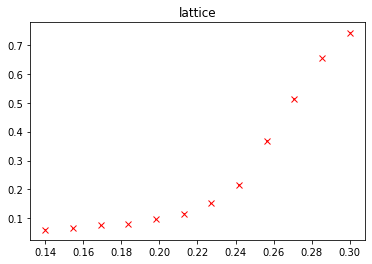

Body centered cubic
{'B': '0',
 'J': '1',
 'L': '6',
 'b': '0.123636',
 'cell.N': '2',
 'f': '../cellfiles/bodyCenteredCubic_cell.txt',
 'model_size': '432',
 'p': '0.12',
 't': '50001'}


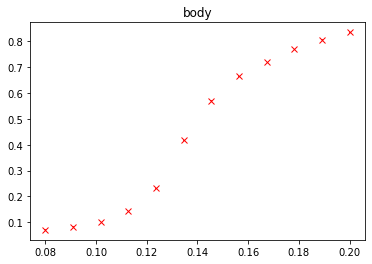

Face centered cubic
{'B': '0',
 'J': '1',
 'L': '5',
 'b': '0.189091',
 'cell.N': '4',
 'f': '../cellfiles/faceCenteredCubic_cell.txt',
 'model_size': '500',
 'p': '0.12',
 't': '50001'}


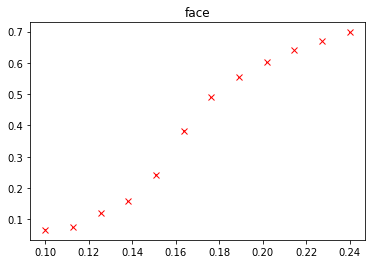

Diamond cubic
{'B': '0',
 'J': '1',
 'L': '4',
 'b': '0.34',
 'cell.N': '8',
 'f': '../cellfiles/diamond_cell.txt',
 'model_size': '512',
 'p': '0.12',
 't': '50001'}


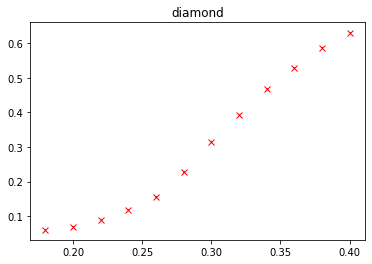

In [3]:
# Phase 1: get rough estimate of beta_c for all crystals
test_folder = '../sim_data/rough_005/'
Path(test_folder).mkdir(exist_ok=True)

for slug, crystal in crystals.items():
    print(crystal['name'])
    s = sim.Span(test_folder+slug)
    if not s.runned:
        s.run('b', crystal['bb'], load=True, log=True, **crystal['params'])
    pprint(s.simulations[0].kwargs)
    bb = []; mm = []; err = []
    DISCARD = 2000
    for simul in s.simulations:
        bb.append(float(simul.kwargs['b']))
        absm = np.abs(simul.data['m'])[DISCARD:]
        mm.append(np.mean(absm))
        err.append(sim.bootstrap(absm))
    plt.errorbar(bb, mm, err, ecolor="red", fmt="rx")
    plt.title(slug)
    plt.show()

Approaching L=7
Span.run tqdm


100%|██████████| 12/12 [03:01<00:00, 15.09s/it]

Approaching L=10
Span.run tqdm



100%|██████████| 12/12 [03:45<00:00, 18.81s/it]

Approaching L=13
Span.run tqdm



100%|██████████| 12/12 [04:11<00:00, 20.99s/it]

Approaching L=16
Span.run tqdm



100%|██████████| 12/12 [04:36<00:00, 23.06s/it]

Approaching L=19
Span.run tqdm



100%|██████████| 12/12 [05:18<00:00, 26.51s/it]

Approaching L=22
Span.run tqdm



100%|██████████| 12/12 [06:23<00:00, 31.98s/it]

Loading spans



100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

Loading spans



100%|██████████| 6/6 [00:03<00:00,  1.65it/s]


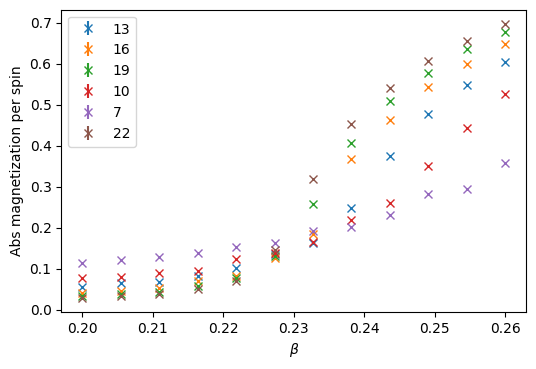

In [4]:
LL_path = "../sim_data/LL008"
my_LL = coll.LL(LL_path)
lattice_crystal = crystals['lattice']
params = lattice_crystal['params']
ll = lattice_crystal['LL']
bb = lattice_crystal['bb']

if not my_LL.runned:
    my_LL.run(ll, bb, **params)

my_LL._load(DISCARD=2000, load=True)

plt.figure(dpi=100)
for L, data in my_LL.data.items():
    plt.errorbar(data['b'], data['m'], data['m_err'], fmt="x", label=str(L))

plt.legend()
plt.ylabel('Abs magnetization per spin')
plt.xlabel('$\\beta$')
plt.show()

In [5]:
# Phase 3: hand plot, with guesses of nu, beta, beta_c, yy = \tilda m_0(L^{1/\nu}*t) = m*L^{\beta/\nu} vs xx = L^{1/\nu}*t
# --SKIPPED

In [6]:
# Phase 4: Implement the multiple histogram method to handle continuous values of beta
for L, data in my_LL.data.items():
    print("Examining L={}".format(L), flush=True)
    ## Compute the ZZ for the simulations we have
    span = [s for s in my_LL.spans if int(s.simulations[0].kwargs['L']) == L][0]
    ZZ = np.array([1.0]*len(span.simulations))
    betas = sorted([float(simul.kwargs['b']) for simul in span.simulations])
    for i in tqdm(range(10000)):
        Zlast = ZZ
        ZZ = [coll.obs_avg(beta, span, Zlast, DISCARD=2000, loaded=True) for beta in betas]
        if ZZ[0]/Zlast[0] > 0.98:
            break # Non scassiamo con troppa precisione
    print("Zlast", Zlast)
    print("ZZ", ZZ)
    data['Z'] = ZZ # Oh sì non mi confonderò mai
    ## Compute ZZ for the continuum bb using the accurate discrete ones
    data['bb'] = np.linspace(np.min(data['b']), np.max(data['b']), 20)
    data['ZZ'] = np.array([coll.obs_avg(b, span, ZZ, DISCARD=2000, loaded=True) for b in data['bb']])
    ## Compute mm
    def get_m(simul):
        return np.abs(simul.data['m'])
    data['mm'] = (
        np.array([coll.obs_avg(b, span, ZZ, obs=get_m, DISCARD=2000, loaded=True) for b in data['bb']])
        / data['ZZ']
    )

Examining L=13


  1%|          | 55/10000 [00:05<15:26, 10.74it/s]


Zlast [2.3377650288989745e-45, 9.245589083365478e-42, 5.403567582823093e-38, 4.875498767526793e-34, 7.109863917635668e-30, 1.808843967286291e-25, 9.020572976764964e-21, 1.1129181692528084e-15, 5.12654432634095e-10, 0.00120424128155369, 13257.735986656817, 579743912500.7579]
ZZ [2.292072040112514e-45, 9.072103847806423e-42, 5.308711812900931e-38, 4.798614911355042e-34, 7.015780968515046e-30, 1.7913128267857784e-25, 8.978134423809896e-21, 1.1159668260156133e-15, 5.193319733897414e-10, 0.0012313521982435232, 13639.68872145376, 598397331262.064]
Examining L=16


  1%|          | 119/10000 [00:10<15:10, 10.85it/s]


Zlast [2.8784240199632843e-88, 2.096770842732938e-81, 3.2523251097565692e-74, 1.157339208884234e-66, 1.0566901448761597e-58, 3.0631749305936952e-50, 4.1386152510289435e-41, 6.989322910273073e-31, 3.428149198953953e-19, 3.2956672013990313e-06, 509188091.35061204, 9.845255674616265e+23]
ZZ [2.821251561202999e-88, 2.0563510107798941e-81, 3.1928756105770246e-74, 1.1380180441889571e-66, 1.0415863950337034e-58, 3.03047470237526e-50, 4.118916147280545e-41, 7.029858165014049e-31, 3.4818835982147185e-19, 3.372268366428536e-06, 523607554.00172406, 1.0148549694952285e+24]
Examining L=19


  0%|          | 0/10000 [00:00<?, ?it/s]/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
  2%|▏         | 219/10000 [00:20<15:22, 10.60it/s]


Zlast [4.055832376614417e-152, 1.8091209235243394e-140, 2.9977291259114747e-128, 2.174318065272453e-115, 8.816673143342328e-102, 3.2553563732705635e-87, 2.7705700768953426e-71, 3.9486256369380647e-53, 1.8563376297684678e-32, 1.59794864676629e-09, 1.5638811129377456e+16, 1.0313366679883058e+43]
ZZ [3.9750347704985405e-152, 1.7739681574689307e-140, 2.9422922294960027e-128, 2.1374951832439855e-115, 8.689051308849286e-102, 3.220913838011064e-87, 2.760251375199575e-71, 3.975374013019738e-53, 1.8862958151678584e-32, 1.6348641423989097e-09, 1.6072486144009606e+16, 1.0620863070829494e+43]
Examining L=10


  0%|          | 21/10000 [00:02<15:53, 10.46it/s]


Zlast [2.35217952841947e-19, 8.900212040919198e-18, 3.9586142096821344e-16, 2.103558023458727e-14, 1.3601515220596834e-12, 1.0996433099900142e-10, 1.1485464047744404e-08, 1.6318841130801503e-06, 0.00034016796934895006, 0.11639590513967434, 72.7553233779732, 86358.22035482059]
ZZ [2.3096170287964597e-19, 8.749385192390262e-18, 3.897622352932532e-16, 2.075467275998177e-14, 1.3456655506081978e-12, 1.0917782969054237e-10, 1.145442229173373e-08, 1.6366065635806825e-06, 0.0003434906220146038, 0.11843271978374478, 74.5445048224262, 88910.59055503257]
Examining L=7


  0%|          | 7/10000 [00:00<17:20,  9.61it/s]


Zlast [4.833864481763327e-06, 1.552035500105701e-05, 5.2375513698252094e-05, 0.0001864419136513587, 0.0007024464002049976, 0.0028157625282609604, 0.012072765647455878, 0.055800236280118466, 0.2803957455157591, 1.549968217736657, 9.547258980832003, 66.60720382749567]
ZZ [4.77944199988016e-06, 1.5366354341555465e-05, 5.1935320801937745e-05, 0.0001851958209951843, 0.0006991168183462613, 0.0028085668217190216, 0.01207132983525503, 0.05594376311754724, 0.28193816307520037, 1.5633385395147579, 9.660582249450247, 67.61395023638227]
Examining L=22


  0%|          | 41/10000 [00:04<17:14,  9.62it/s]/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in add
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
  4%|▎         | 364/10000 [00:37<16:42,  9.61it/s]


Zlast [4.784050085644223e-242, 9.804562795407422e-224, 1.6426212195776137e-204, 2.8463784222278776e-184, 8.035851108067773e-163, 9.647523575999003e-140, 4.439619785749196e-114, 2.3490600625127725e-84, 6.928934966989641e-51, 7.458983139316974e-14, 1.089868973454067e+27, 9.354232295219893e+69]
ZZ [4.689001368433123e-242, 9.614041786425523e-224, 1.612098861284458e-204, 2.7976933012411175e-184, 7.917150282161075e-163, 9.545009037214574e-140, 4.4304799188796515e-114, 2.367403638787225e-84, 7.043464211470305e-51, 7.629330060029926e-14, 1.1189623459655902e+27, 9.621495039889694e+69]


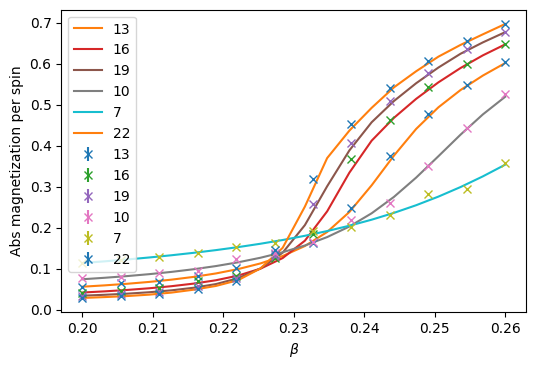

In [7]:
plt.figure(dpi=100)
for L, data in my_LL.data.items():
    plt.errorbar(data['b'], data['m'], data['m_err'], fmt="x", label=str(L))
    plt.plot(data['bb'], data['mm'], label=str(L))
plt.legend()
plt.ylabel('Abs magnetization per spin')
plt.xlabel('$\\beta$')
plt.show()

1
0.6 0.33 0.225


/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))


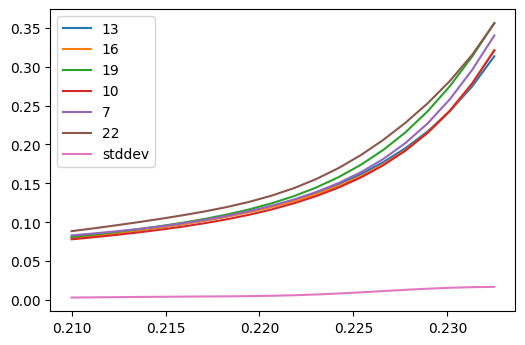

0.6 0.39 0.225


/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))


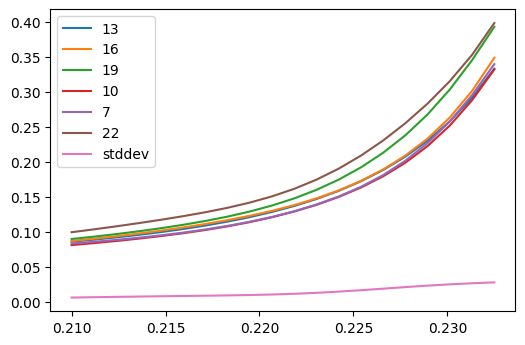

2
0.6 0.33 0.225


/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))


0.6 0.33 0.225
0.6 0.33 0.225
0.6000000089406967 0.33 0.225
0.6 0.3300000049173832 0.225
0.6 0.33 0.22500000335276127
0.5586190258167694 0.1755497168395454 0.22531166695479019
0.6076616205722656 0.2878784883258278 0.22433255891452958
0.6076616296271293 0.2878784883258278 0.22433255891452958
0.6076616205722656 0.28787849261555154 0.22433255891452958
0.6076616205722656 0.2878784883258278 0.22433256225734519
0.62394345828959 0.3374487917528132 0.22486192930701418
0.6212180437659409 0.3034445938474884 0.2245164397492655
0.6212180530228111 0.3034445938474884 0.2245164397492655
0.6212180437659409 0.3034445983691652 0.2245164397492655
0.6212180437659409 0.3034445938474884 0.22451644309482116
0.6276006985404248 0.3138450247299737 0.22425533572379164
0.627600707892404 0.3138450247299737 0.22425533572379164
0.6276006985404248 0.313845029406629 0.22425533572379164
0.6276006985404248 0.3138450247299737 0.22425533906545655
0.6464095222705349 0.35475599169129857 0.2240947991235064
0.6331135021244982

/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in multiply
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))
/home/1998marcom/DElia/metodi-numerici-mod-1/conti/analysis/collapser.py:113: RuntimeWarning: overflow encountered in exp
  denom += bn[j][1] / Zin[j] * np.exp(-(bn[j][0]-beta)*simul.data['u'][DISCARD:]*int(simul.kwargs['model_size']))


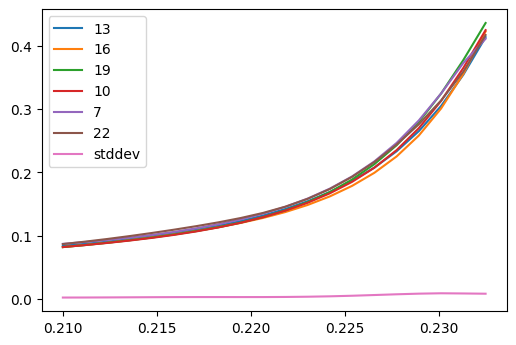

In [12]:
# Phase 5: use an implicit fit to find \nu, \beta, \beta_c from the curve functions above
plt.figure(dpi=100)
def curve_stddev(bb, nu, beta, beta_c, plot=False): 
    # Note that bb is beta for L_min and beta is the critical exponent, not the inverse temperature
    """
    This function returns the stddev of the different curves.
    You should optimize it to be 0 everywhere.
    If you opt for the least squares method, you are effectively
    minimizing the integral of the variance.
    We also require a few global parameters to be set:
    - collapser.my_LL: the LL where to take data from. In particular:
        - data:
            4: the L parameter of the span
                - 'b': The betas of the simulations
                - 'Z': The partition functions
            5: the L parameter ...
    """
    #beta_c=0.223
    print(nu, beta, beta_c)
    L_min = np.min(list(my_LL.data.keys()))
    #print(L_min)
    for L, data in my_LL.data.items():
        #print(L)
        data['xx'] = bb
        data['local_bb'] = np.power(L_min/L, 1/nu)*(bb-beta_c)/beta_c+beta_c
        span = [s for s in my_LL.spans if int(s.simulations[0].kwargs['L']) == L][0]
        #print(data['local_bb'], data['Z'])
        data['local_ZZ'] = np.array([coll.obs_avg(b, span, data['Z'], loaded=True) for b in data['local_bb']])
        mh_mm = np.array([
            coll.obs_avg(b, span, data['Z'], obs=lambda simul: np.abs(simul.data['m']), DISCARD=2000, loaded=True)
            for b in data['local_bb']
        ]) / data['local_ZZ']
        #print(mh_mm)
        data['yy'] = np.power(L/L_min, beta/nu)*mh_mm
        #print(data['yy'])
        if plot:
            plt.plot(data['xx'], data['yy'], label=str(L))
    out_from_curves = np.array([data['yy'] for data in my_LL.data.values()])
    result = np.std(out_from_curves, axis=0)
    #print(np.linalg.norm(result))
    return result

bb = np.linspace(0.21, 0.2325, 20)
from scipy.optimize import curve_fit
p0 = (0.6, 0.33, 0.225)
print(1)
plt.plot(bb, curve_stddev(bb, *p0, plot=True), label='stddev')
plt.legend()
plt.show()
plt.figure(dpi=100)
plt.plot(bb, curve_stddev(bb, *(0.6, 0.39, 0.225), plot=True), label='stddev')
plt.legend()
plt.show()
print(2)
popt, pcov = curve_fit(curve_stddev, bb, np.zeros(len(bb)), p0=p0)
print(popt, np.sqrt(np.diag(pcov)))
plt.figure(dpi=100)
plt.plot(bb, curve_stddev(bb, *popt, plot=True), label='stddev')
plt.legend()
plt.show()

In [9]:
print(popt)
print(pcov)

[0.64545361 0.3890495  0.22299153]
[[ 9.87554038e-03 -1.00707626e-02 -5.57626130e-05]
 [-1.00707626e-02  1.16624857e-02  2.43300495e-05]
 [-5.57626130e-05  2.43300495e-05  6.95601334e-06]]
